# Statistics Coded: How do women and men use their time - statistics 

This noteboook reproduces step by step the figures avialable in the original [Statistics Explaind page](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=How_do_women_and_men_use_their_time_-_statistics) and in the [source excel file](https://ec.europa.eu/eurostat/statistics-explained/images/2/2e/SE_Article_Charts_HETUS_2010_FINAL_06.09.2019.xlsx).

We define the year in a variable `yr<-2010` so if i want to rerun the code for a different year we have to change only this line. In addition we will retrieve the EU28 country names which will be used in later steps.

In [1]:
library(restatapi)
library(ggplot2)
library(chron)
yr<-"2010"
eu_ctry_names<-do.call(rbind,lapply(get("cc",envir=.restatapi_env)$EU28,search_eurostat_dsd,dsd=get_eurostat_dsd("tus_00age"),exact_match=TRUE))$name
eu_ctry_names<-gsub(" \\(.*\\)","",eu_ctry_names)

restatapi: - config file with the API version 1 loaded from GitHub (the 'current' API version number is 1).
           - 4 from the 32 cores are used for parallel computing, can be changed with 'options(restatapi_cores=...)'
           - 'auto' method will be used for file download, can be changed with 'options(restatapi_dmethod=...)'
           - the Table of contents (TOC) was not pre-loaded into the deafult cache ('.restatapi_env').



## Figure 1: Mean time spent on daily activities, all individuals by country, (hh:mm; 2008 to 2015)


The data is in the *tus_00age* dataset. We use the [restatapi](https://github.com/eurostat/restatapi) package to download the data. We apply filter to the data for the year (`date_filter=yr`) . We also filter for the other values in the graph (`filters=list(unit="spent",age="total",sex="total",acl00=c("sleep","eat","^employ"," (family|personal) care","^leisure","^study","except travel"))`. If we use the [REST SDMX](https://ec.europa.eu/eurostat/web/sdmx-web-services/rest-sdmx-2.1) service to get the filtered dataset, then we get no data because all the values are **NaN** (Not a Number) as the values are time spans. In order to get the data we have to apply the filter locally (`force_local_filter=T`) on the dataset retrieved from the bulk download facility.  

In [2]:
#dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",acl00="^(?!total).*$",geo="be"),date_filter=2010,label=F,ignore.case=T,exact_match=F,force_local_filter=T,perl=T)
#dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",acl00=c("ac01","ac02","ac03","ac1a","ac1b","ac2$","ac3$","ac4-8$","ac9a"),geo="be"),date_filter=2010,label=T,ignore.case=T,exact_match=F,force_local_filter=T,perl=T)
#dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",geo="be"),date_filter=2010,label=T,ignore.case=T,exact_match=F,force_local_filter=T,perl=T)
dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",acl00=c("sleep","eat","^employ"," (family|personal) care","^leisure","^study","except travel")),date_filter=eval(yr),label=T,ignore.case=T,exact_match=F,perl=T)
dt
dt<-get_eurostat_data("tus_00age",filters=list(unit="spent",age="total",sex="total",acl00=c("sleep","eat","^employ"," (family|personal) care","^leisure","^study","except travel")),date_filter=eval(yr),label=T,ignore.case=T,exact_match=F,perl=T,stringsAsFactors=F,force_local_filter=T)
dt


unit,sex,acl00,age,geo,time,values
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>


Forcing to apply filter locally. The whole dataset is downloaded through the raw download and the filters are applied locally.



unit,sex,age,acl00,geo,time,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Time spent (hh:mm),Total,Total,Sleep,Austria,2010,8:31
Time spent (hh:mm),Total,Total,Sleep,Belgium,2010,8:36
Time spent (hh:mm),Total,Total,Sleep,Germany (until 1990 former territory of the FRG),2010,8:26
Time spent (hh:mm),Total,Total,Sleep,Estonia,2010,8:50
Time spent (hh:mm),Total,Total,Sleep,Greece,2010,8:36
Time spent (hh:mm),Total,Total,Sleep,Spain,2010,8:38
Time spent (hh:mm),Total,Total,Sleep,Finland,2010,8:35
Time spent (hh:mm),Total,Total,Sleep,France,2010,8:30
Time spent (hh:mm),Total,Total,Sleep,Hungary,2010,8:34


Then we convert the values from characters/factors to time values using the *chron* package and keep only the columns with activities, countries and values. Before plotting the values, we need to sum the eating and other personal care for each country and cut the brackets from the name of Germany.

In [3]:
dt$geo<-gsub(" \\(.*\\)","",dt$geo)
if (is.factor(dt$values)|is.character(dt$values)) dt<-dt[,values:=chron::times(paste0(values,":00"))]
dt<-dt[,c("acl00","geo","values")]
sdt<-dt[grepl("(ating|ther)",acl00),.(acl00="Eating and other personal care",values=sum(values)),by=geo]
sdt
dt<-rbind(dt[!grepl("(ating|ther)",acl00)],sdt)

geo,acl00,values
<chr>,<chr>,<times>
Austria,Eating and other personal care,02:14:00
Belgium,Eating and other personal care,02:37:00
Germany,Eating and other personal care,02:38:00
Estonia,Eating and other personal care,02:16:00
Greece,Eating and other personal care,03:10:00
Spain,Eating and other personal care,02:50:00
Finland,Eating and other personal care,02:12:00
France,Eating and other personal care,03:05:00
Hungary,Eating and other personal care,02:58:00


Then plot the data using the *ggplot2* library, and using the color codes of the original figure.

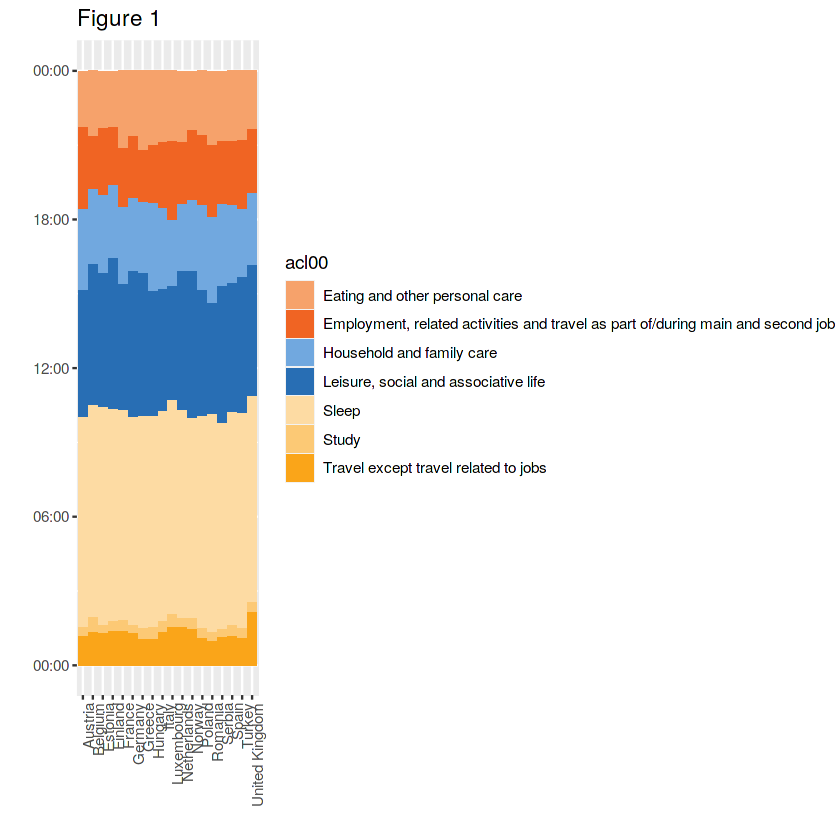

In [4]:
fig1_colors<-c("#F6A26B","#F06423","#71A8DF","#286EB4","#FDDBA3","#FCC975","#FAA519")
ggplot(dt, aes(x=geo, y=values,fill=acl00)) + 
  geom_bar(position="stack",stat="identity")+
  scale_y_chron(format="%H:%M") +
  scale_fill_manual(values = fig1_colors)+
  ggtitle("Figure 1") +
  ylab ("")+
  xlab("")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

The graph not exactly as in the SE article, because in our case it is sorted alphabetically. We have to add the empty spaces before the EFTA and accession countries and reorder the values. Finally adjust scaling, remove vertical grid lines, column width and resize the plotting area to better see the figure. 

Warning message:
"Removed 2 rows containing missing values (position_stack)."


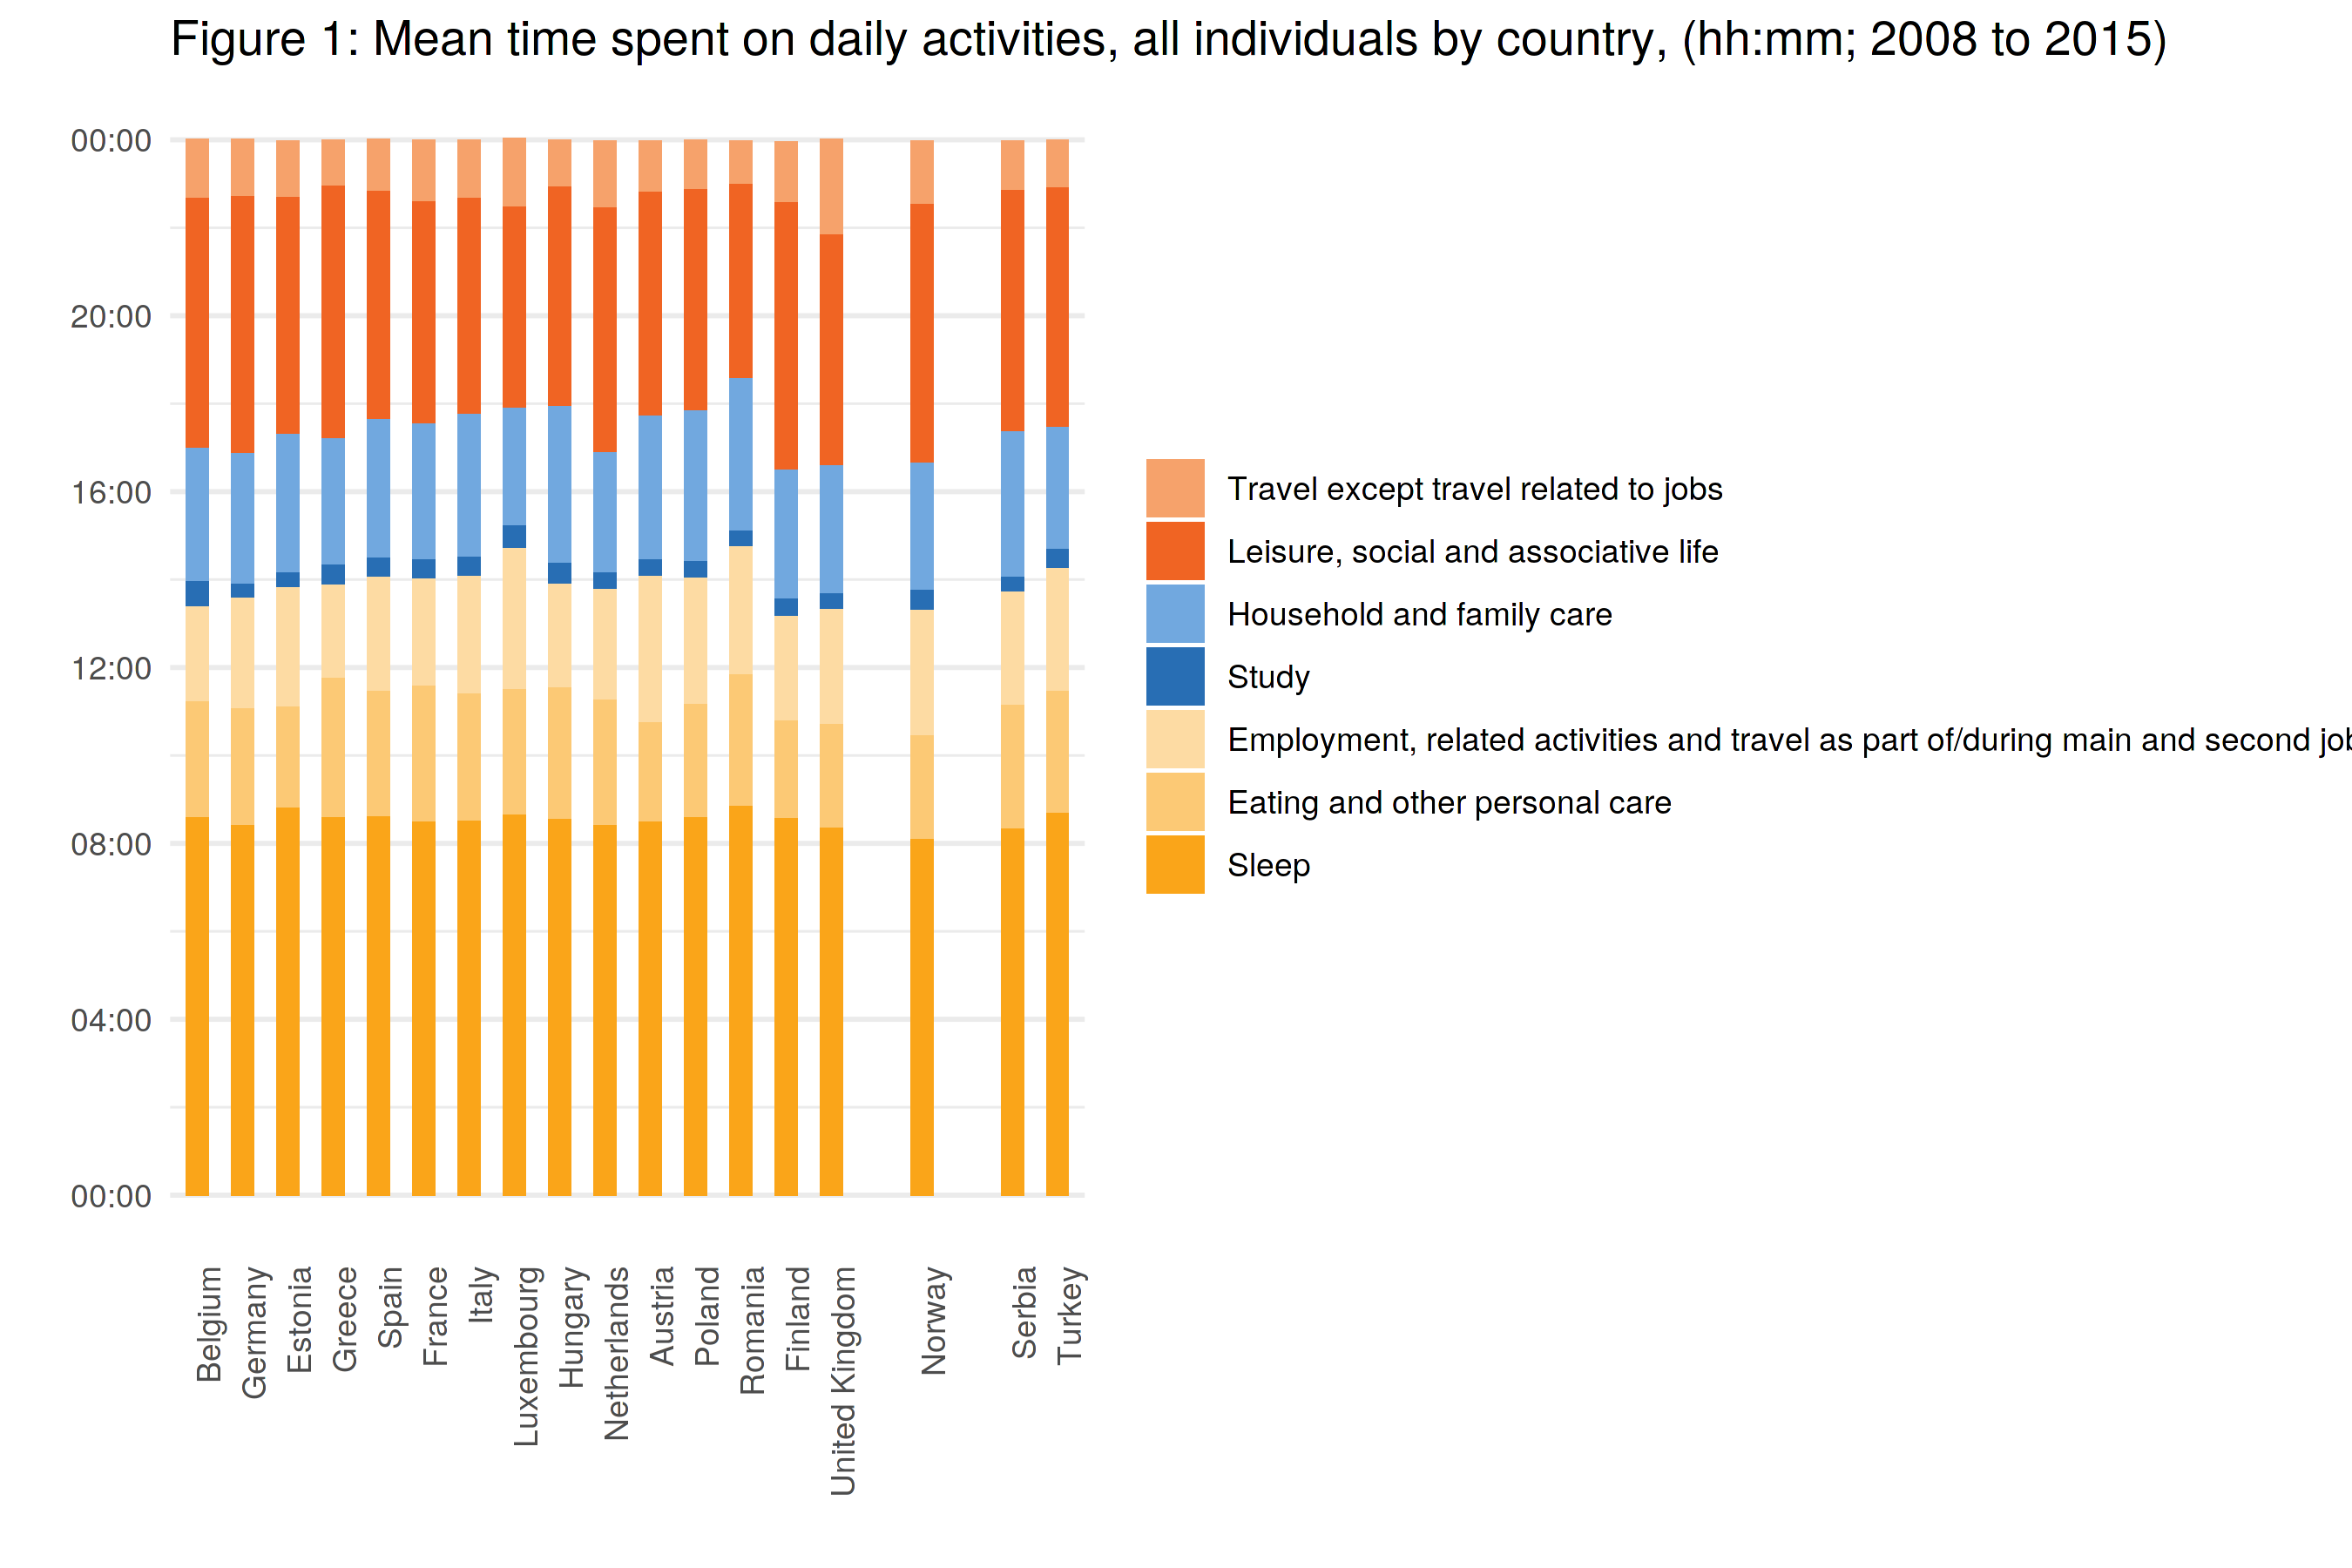

In [5]:
dt_sep<-data.table::data.table(acl00=c("Sleep","Sleep"),geo=c(" ","  "),values=c(chron::times(NA),chron::times(NA)))
dt<-rbind(dt,dt_sep)
acls_ord<-c('Travel except travel related to jobs','Leisure, social and associative life','Household and family care','Study','Employment, related activities and travel as part of/during main and second job','Eating and other personal care','Sleep')
dt$acl00<-factor(dt$acl00,levels=acls_ord)
geo_ord<-c('Belgium','Germany','Estonia','Greece','Spain','France','Italy','Luxembourg','Hungary','Netherlands','Austria','Poland','Romania','Finland','United Kingdom',' ','Norway','  ','Serbia','Turkey')
dt$geo<-factor(dt$geo,levels=geo_ord)

options(repr.plot.width=9, repr.plot.height=6,repr.plot.res=300)
ggplot(dt, aes(x=geo, y=values,fill=acl00)) + theme_minimal() +
  geom_bar(position="stack",stat="identity",width=0.5)+
  scale_y_chron(format="%H:%M",breaks=seq(0,1,4/24)) +
  scale_fill_manual(values = fig1_colors)+
  ggtitle("Figure 1: Mean time spent on daily activities, all individuals by country, (hh:mm; 2008 to 2015)") +
  ylab("")+
  xlab("")+
  theme(legend.title = element_blank(), 
        axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid.major.x = element_blank())

## Figure 2: Participation time per day in study and employment, only individuals taking part in the activity, by country, (hh mm; 2008 to 2015)

The data is again in the *tus_00age* dataset. We use the same method as for Figure 1. We apply the same filter to the data for the year (`date_filter=yr`) and a modified one for the values in the graph (`filters=list(unit="Participation time",age="total",sex="total",acl00=c("^study","^empl"))`. Again in order to get the data we have to apply the filter locally (`force_local_filter=T`) on the dataset retrieved from the bulk download facility. 

In [6]:
dt<-get_eurostat_data("tus_00age",filters=list(unit="Participation time",age="total",sex="total",acl00=c("^study","^empl")),date_filter=eval(yr),label=T,ignore.case=T,exact_match=F,perl=T,stringsAsFactors=F,force_local_filter=T)
dt

Forcing to apply filter locally. The whole dataset is downloaded through the raw download and the filters are applied locally.



unit,sex,age,acl00,geo,time,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",Austria,2010,7:45
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",Belgium,2010,7:24
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",Germany (until 1990 former territory of the FRG),2010,7:02
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",Estonia,2010,7:52
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",Greece,2010,7:20
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",Spain,2010,7:24
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",Finland,2010,7:17
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",France,2010,6:51
Participation time (hh:mm),Total,Total,"Employment, related activities and travel as part of/during main and second job",Hungary,2010,7:12


Then again we convert the values from characters/factors to time values using the *chron* package and keep only the columns with activities, countries and values. Before plotting the values we need to cut the brackets from the name of Germany.

In [7]:
dt$geo<-gsub(" \\(.*\\)","",dt$geo)
if (is.factor(dt$values)|is.character(dt$values)) dt<-dt[,values:=chron::times(paste0(values,":00"))]
dt<-dt[,c("acl00","geo","values")]
dt

acl00,geo,values
<chr>,<chr>,<times>
"Employment, related activities and travel as part of/during main and second job",Austria,07:45:00
"Employment, related activities and travel as part of/during main and second job",Belgium,07:24:00
"Employment, related activities and travel as part of/during main and second job",Germany,07:02:00
"Employment, related activities and travel as part of/during main and second job",Estonia,07:52:00
"Employment, related activities and travel as part of/during main and second job",Greece,07:20:00
"Employment, related activities and travel as part of/during main and second job",Spain,07:24:00
"Employment, related activities and travel as part of/during main and second job",Finland,07:17:00
"Employment, related activities and travel as part of/during main and second job",France,06:51:00
"Employment, related activities and travel as part of/during main and second job",Hungary,07:12:00


We make the graph again with *ggplot*. We have to order by increasing value of *Employment*, add the empty spaces before the EFTA and accession countries. Finally adjust scaling, remove vertical grid lines, column width and resize the plotting area to better see the figure. 

Warning message:
"Removed 2 rows containing missing values (geom_bar)."


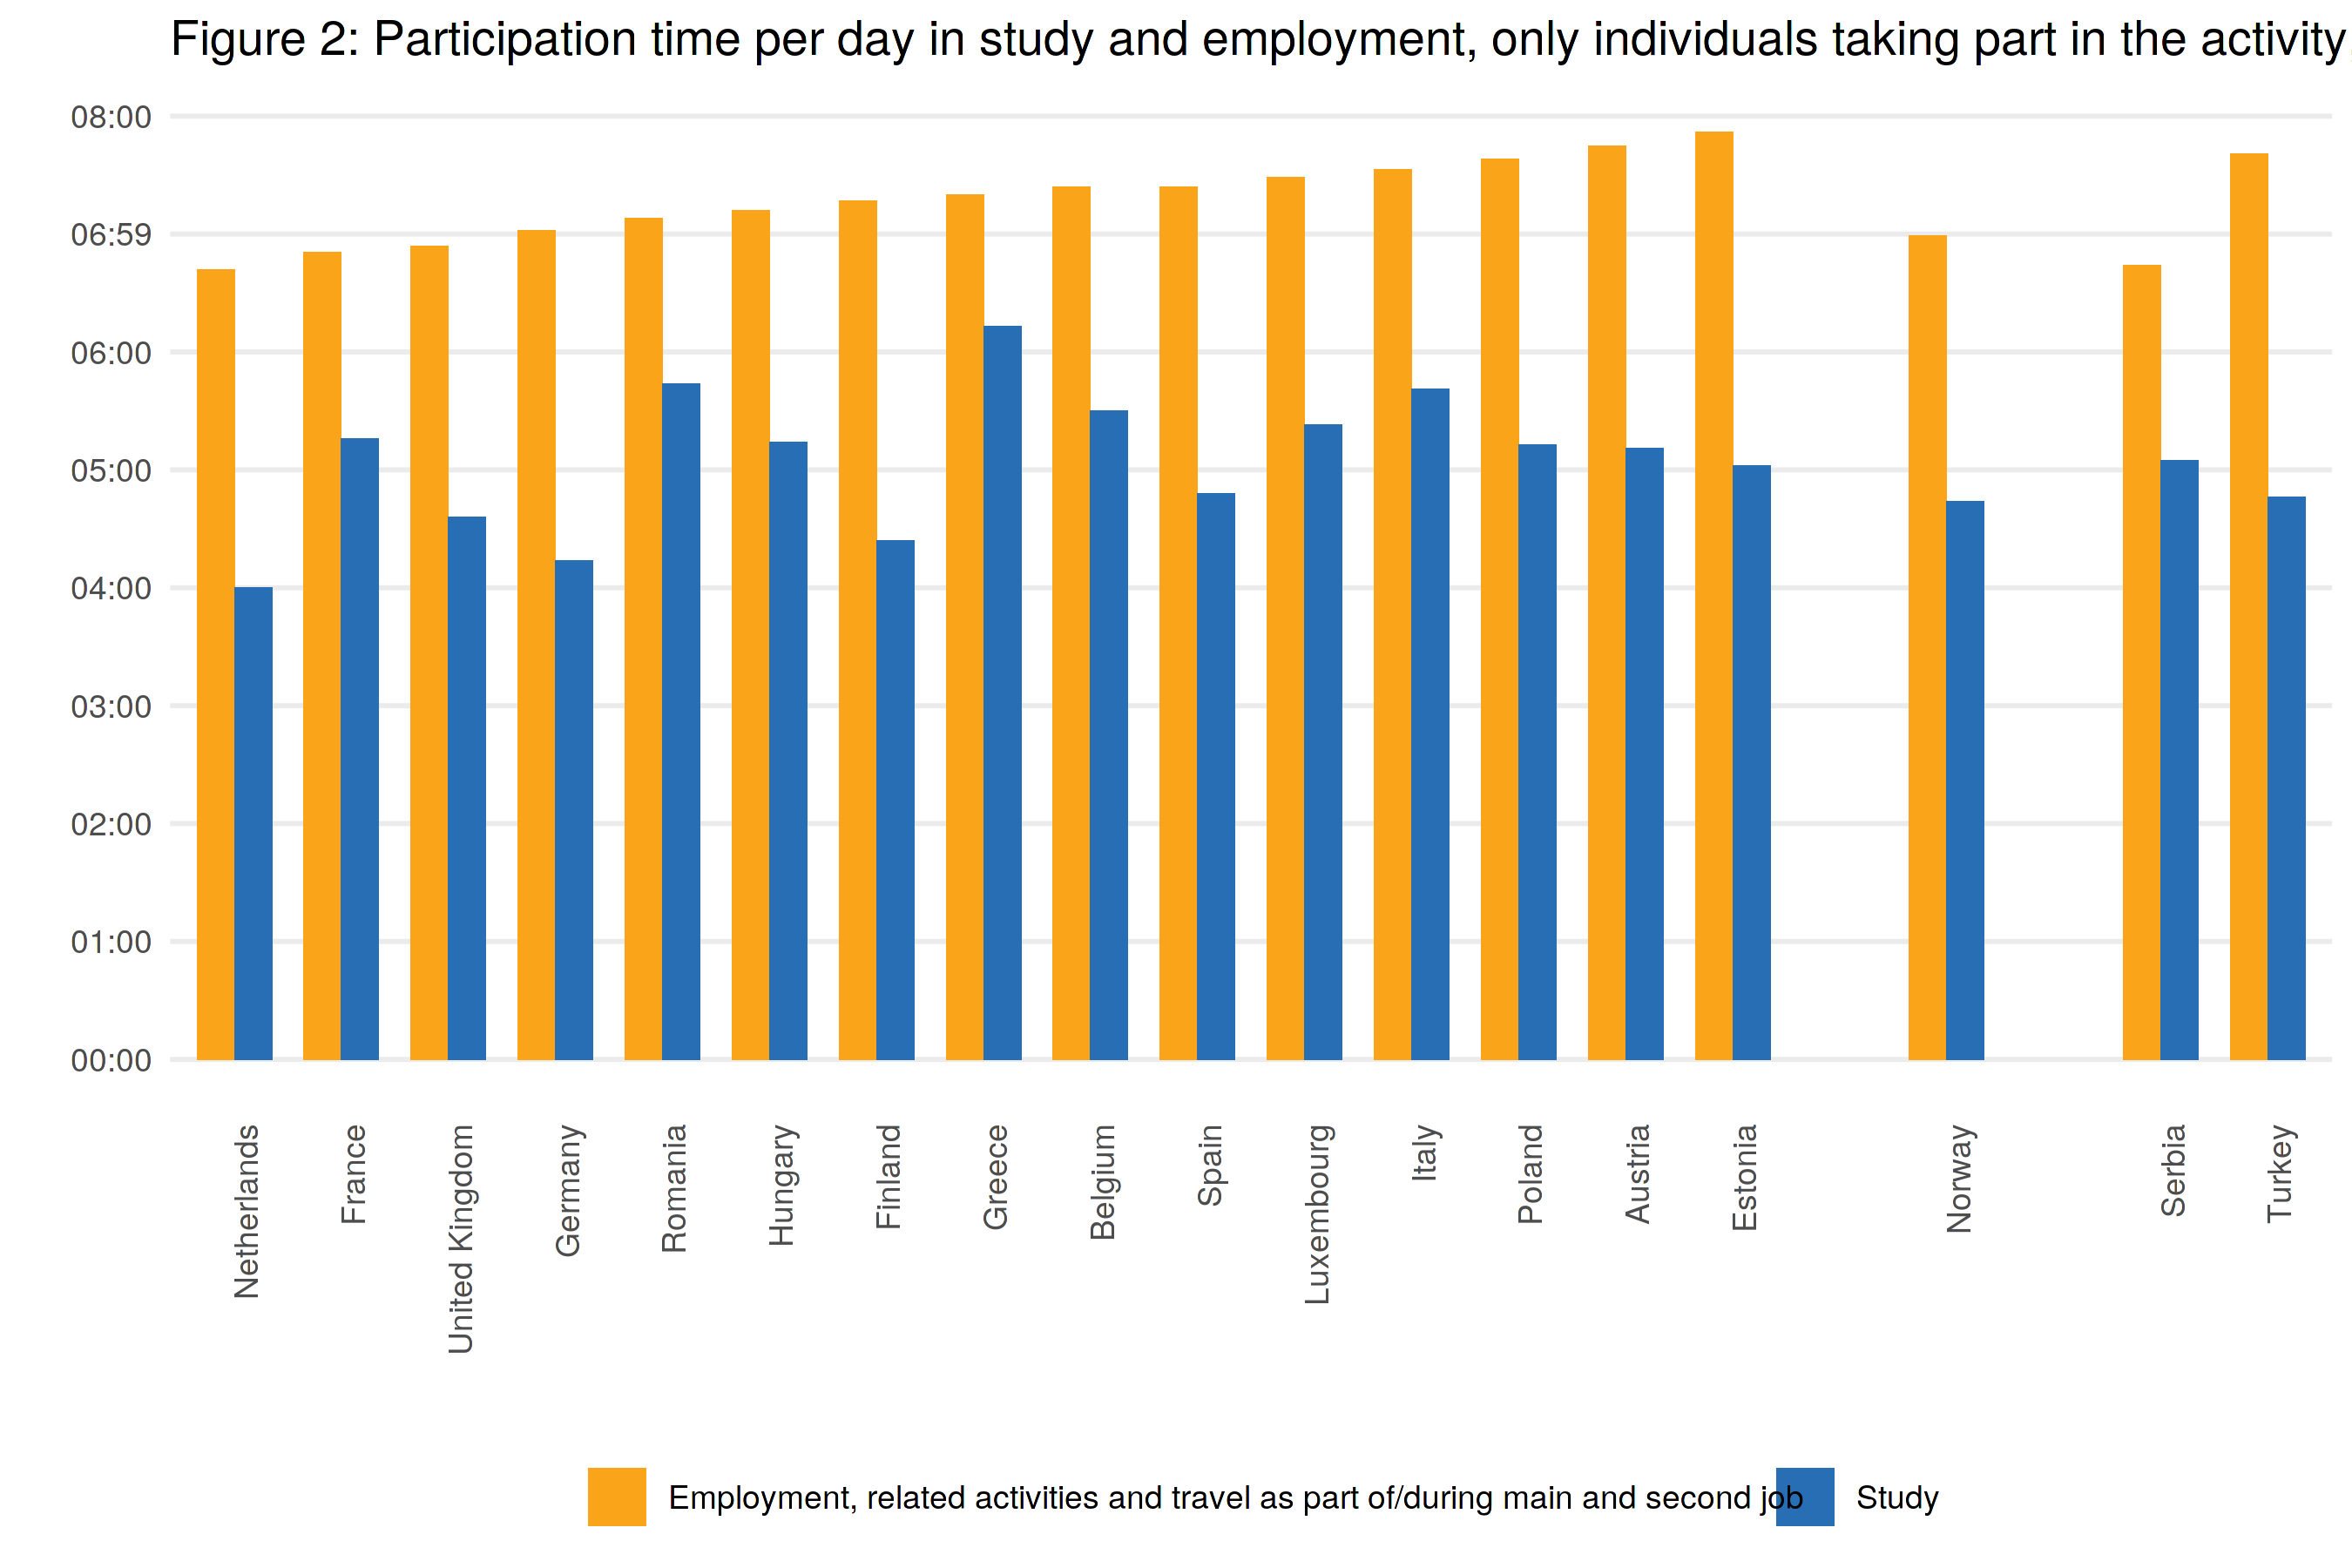

In [8]:
dt_sep<-data.table::data.table(acl00=c("Study","Study"),geo=c(" ","  "),values=c(chron::times(NA),chron::times(NA)))
dt<-rbind(dt,dt_sep)
geo_ord<-dt[(geo %in% eu_ctry_names)&grepl("Empl",acl00)]
geo_ord<-geo_ord[order(values)]$geo
geo_ord<-c(geo_ord,' ','Norway','  ','Serbia','Turkey')
dt$geo<-factor(dt$geo,levels=geo_ord)
fig2_colors<-c("#FAA519","#286EB4")

options(repr.plot.width=9, repr.plot.height=6,repr.plot.res=300)
ggplot(dt, aes(x=geo, y=values,fill=acl00)) + theme_minimal() +
  geom_bar(position="dodge",stat="identity",width=0.7)+
  scale_y_chron(format="%H:%M",breaks=seq(0,1,1/24)) +
  scale_fill_manual(values = fig2_colors)+
  ggtitle("Figure 2: Participation time per day in study and employment, only individuals taking part in the activity, by country, (hh mm; 2008 to 2015)") +
  ylab("")+
  xlab("")+
  theme(legend.title = element_blank(),
        legend.position= "bottom",
        axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank())

## Figure 3: Participation time per day in household and family care, by gender, (hh mm; 2008 to 2015)

The data is again in the *tus_00age* dataset. We use the same method as for Figure 1. We apply the same filter to the data for the year (`date_filter=yr`) and a modified one for the values in the graph (`filters=list(unit="Participation time",age="total",acl00="household.*care")`. Again in order to get the data we have to apply the filter locally (`force_local_filter=T`) on the dataset retrieved from the bulk download facility. 

In [9]:
dt<-get_eurostat_data("tus_00age",filters=list(unit="Participation time",age="total",acl00="household.*care"),date_filter=eval(yr),label=T,ignore.case=T,exact_match=F,perl=T,stringsAsFactors=F,force_local_filter=T)
dt

Forcing to apply filter locally. The whole dataset is downloaded through the raw download and the filters are applied locally.



unit,sex,age,acl00,geo,time,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Participation time (hh:mm),Females,Total,Household and family care,Austria,2010,4:32
Participation time (hh:mm),Females,Total,Household and family care,Belgium,2010,3:58
Participation time (hh:mm),Females,Total,Household and family care,Germany (until 1990 former territory of the FRG),2010,3:50
Participation time (hh:mm),Females,Total,Household and family care,Estonia,2010,4:05
Participation time (hh:mm),Females,Total,Household and family care,Greece,2010,4:28
Participation time (hh:mm),Females,Total,Household and family care,Spain,2010,4:36
Participation time (hh:mm),Females,Total,Household and family care,Finland,2010,3:41
Participation time (hh:mm),Females,Total,Household and family care,France,2010,4:04
Participation time (hh:mm),Females,Total,Household and family care,Hungary,2010,4:43


Then again we convert the values from characters/factors to time values using the *chron* package and keep only the columns with sex, countries and values. Before plotting the values we need to cut the brackets from the name of Germany.

In [10]:
dt$geo<-gsub(" \\(.*\\)","",dt$geo)
if (is.factor(dt$values)|is.character(dt$values)) dt<-dt[,values:=chron::times(paste0(values,":00"))]
dt<-dt[,c("sex","geo","values")]
dt

sex,geo,values
<chr>,<chr>,<times>
Females,Austria,04:32:00
Females,Belgium,03:58:00
Females,Germany,03:50:00
Females,Estonia,04:05:00
Females,Greece,04:28:00
Females,Spain,04:36:00
Females,Finland,03:41:00
Females,France,04:04:00
Females,Hungary,04:43:00


We make the graph again with *ggplot*. We have to order by increasing total value of *sex*, add the empty spaces before the EFTA and accession countries. Finally adjust scaling, remove vertical grid lines, column width and resize the plotting area to better see the figure. 

In [11]:
dt_sep<-data.table::data.table(sex=c("Males","Males"),geo=c(" ","  "),values=c(chron::times(NA),chron::times(NA)))
dt<-rbind(dt,dt_sep)
geo_ord<-dt[(geo %in% eu_ctry_names)&grepl("Total",sex)]
geo_ord<-geo_ord[order(values)]$geo
geo_ord<-c(geo_ord,' ','Norway','  ','Serbia','Turkey')
dt$geo<-factor(dt$geo,levels=geo_ord)
sex_ord<-c('Males','Females',"Total")
dt$sex<-factor(dt$sex,levels=sex_ord)

Warning message:
"Removed 2 rows containing missing values (geom_bar)."


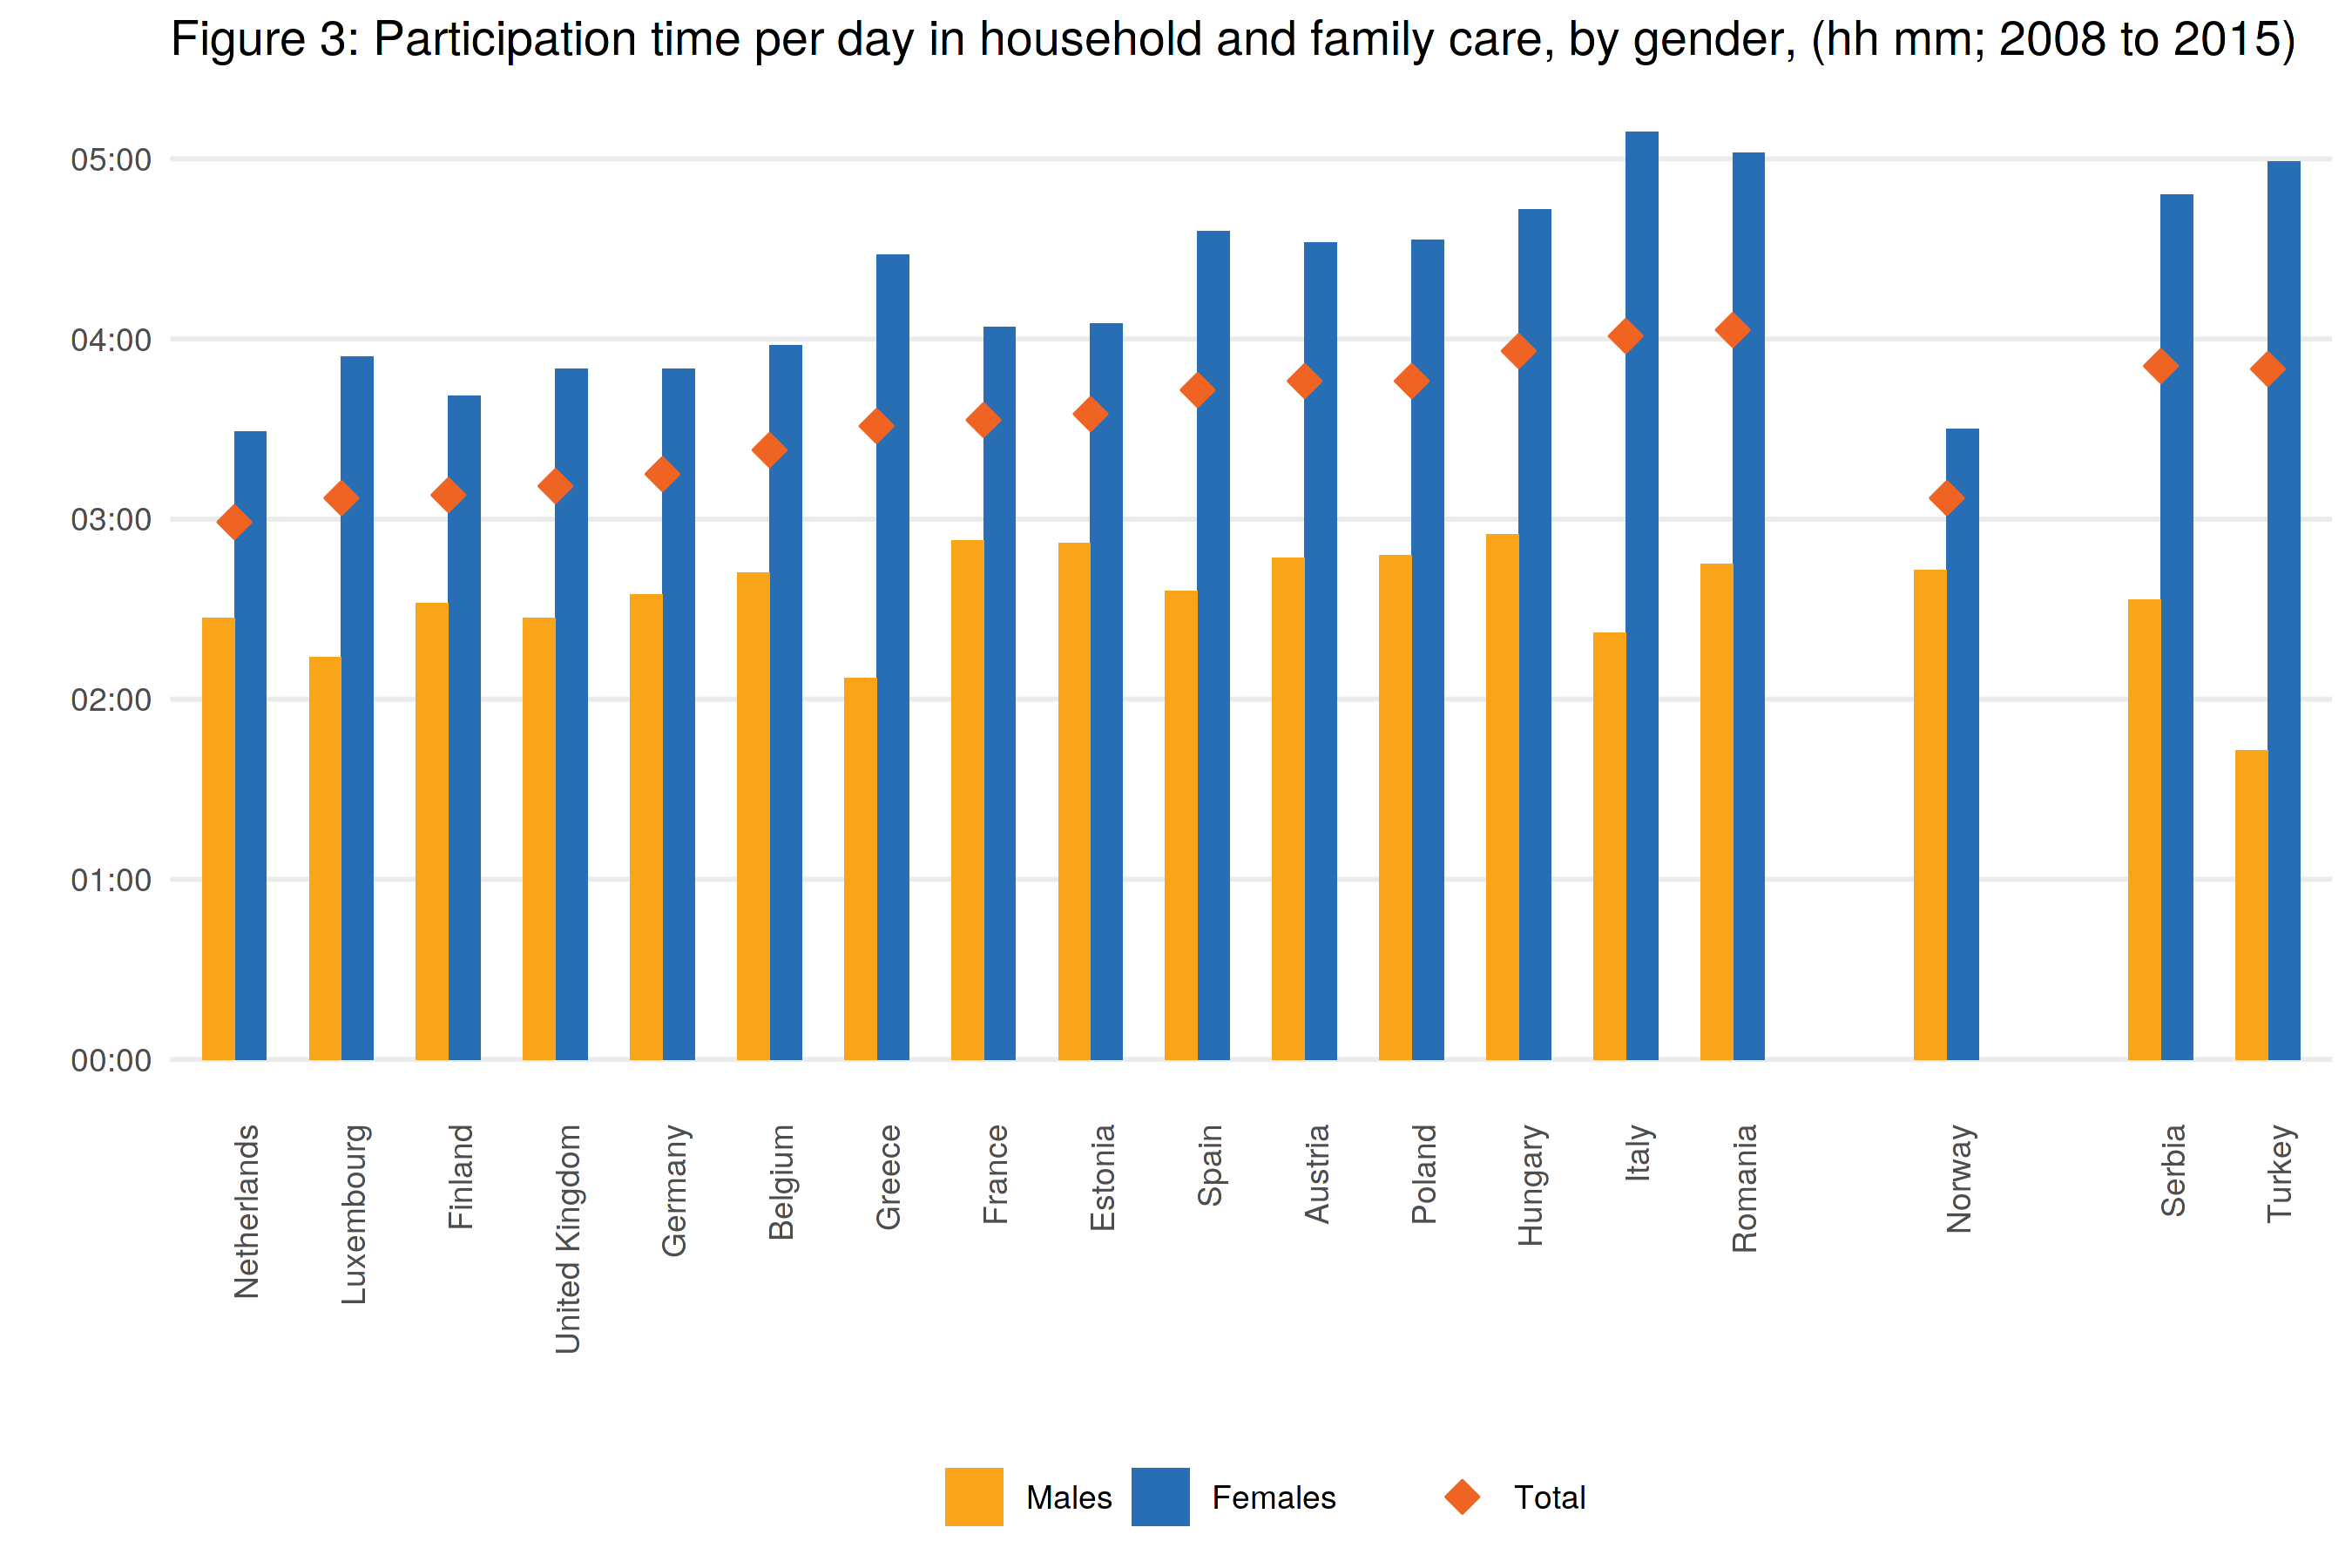

In [12]:
fig3_colors<-c("#FAA519","#286EB4","#F06423")

options(repr.plot.width=9, repr.plot.height=6,repr.plot.res=300)
ggplot(dt,aes(x=geo,y=values)) + theme_minimal() +
  geom_bar(data=dt[sex!="Total"], aes(fill=sex),position="dodge",stat="identity",width=0.6)+
  geom_point(data=dt[grepl("Total",sex)],aes(shape=sex),colour="#F06423",fill="#F06423",size=3)+
  scale_y_chron(format="%H:%M",breaks=seq(0,1,1/24)) +
  scale_fill_manual(values = fig3_colors)+
  scale_shape_manual(values=c("Males"=NA,"Females"=NA,"Total"=23))+
  ggtitle("Figure 3: Participation time per day in household and family care, by gender, (hh mm; 2008 to 2015)") +
  ylab("")+
  xlab("")+
  theme(legend.title = element_blank(),
        legend.position= "bottom",
        axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank())
  


## Figure 4: Participation rate per day in household and family care, main activity, %, by gender (2008 to 2015)

The data is this time in the *tus_00educ* dataset. We apply the same filter to the data for the year (`date_filter=yr`) and a modified one for the values in the graph (`filters=list(unit="Participation rate",age="total",acl00="household.*care",sex="male",isced97="^all")`. This time we can use the SDMX REST API to get the data as it is numeric. 

In [13]:
dt<-get_eurostat_data("tus_00educ",filters=list(unit="Participation rate",age="total",acl00="household.*care",sex="male",isced97="^all"),date_filter=eval(yr),label=T,ignore.case=T,exact_match=F,perl=T,stringsAsFactors=F)
dt

unit,sex,acl00,isced97,geo,time,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Austria,2010,96.4
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Belgium,2010,95.6
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Germany (until 1990 former territory of the FRG),2010,96.3
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Estonia,2010,95.7
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Greece,2010,94.6
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Spain,2010,94.8
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Finland,2010,97.3
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,France,2010,94.8
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Hungary,2010,97.4


Then again we keep only the columns with sex, countries and values. Before plotting the values we need to cut the brackets from the name of Germany.

In [14]:
dt$geo<-gsub(" \\(.*\\)","",dt$geo)
dt<-dt[,c("sex","geo","values")]
dt

sex,geo,values
<chr>,<chr>,<dbl>
Females,Austria,96.4
Females,Belgium,95.6
Females,Germany,96.3
Females,Estonia,95.7
Females,Greece,94.6
Females,Spain,94.8
Females,Finland,97.3
Females,France,94.8
Females,Hungary,97.4


We make the graph again with *ggplot*. We have to order by increasing total value of *sex*, add the empty spaces before the EFTA and accession countries. Finally adjust scaling, remove vertical grid lines, column width and resize the plotting area to better see the figure. 

In [16]:
dt_sep<-data.table::data.table(sex=c("Males","Males"),geo=c(" ","  "),values=c(NA,NA))
dt<-rbind(dt,dt_sep)
geo_ord<-dt[(geo %in% eu_ctry_names)&grepl("Females",sex)]
geo_ord<-geo_ord[order(values)]$geo
geo_ord<-c(geo_ord,' ','Norway','  ','Serbia','Turkey')
dt$geo<-factor(dt$geo,levels=geo_ord)
sex_ord<-c('Males','Females')
dt$sex<-factor(dt$sex,levels=sex_ord)

Warning message:
"Removed 2 rows containing missing values (geom_bar)."


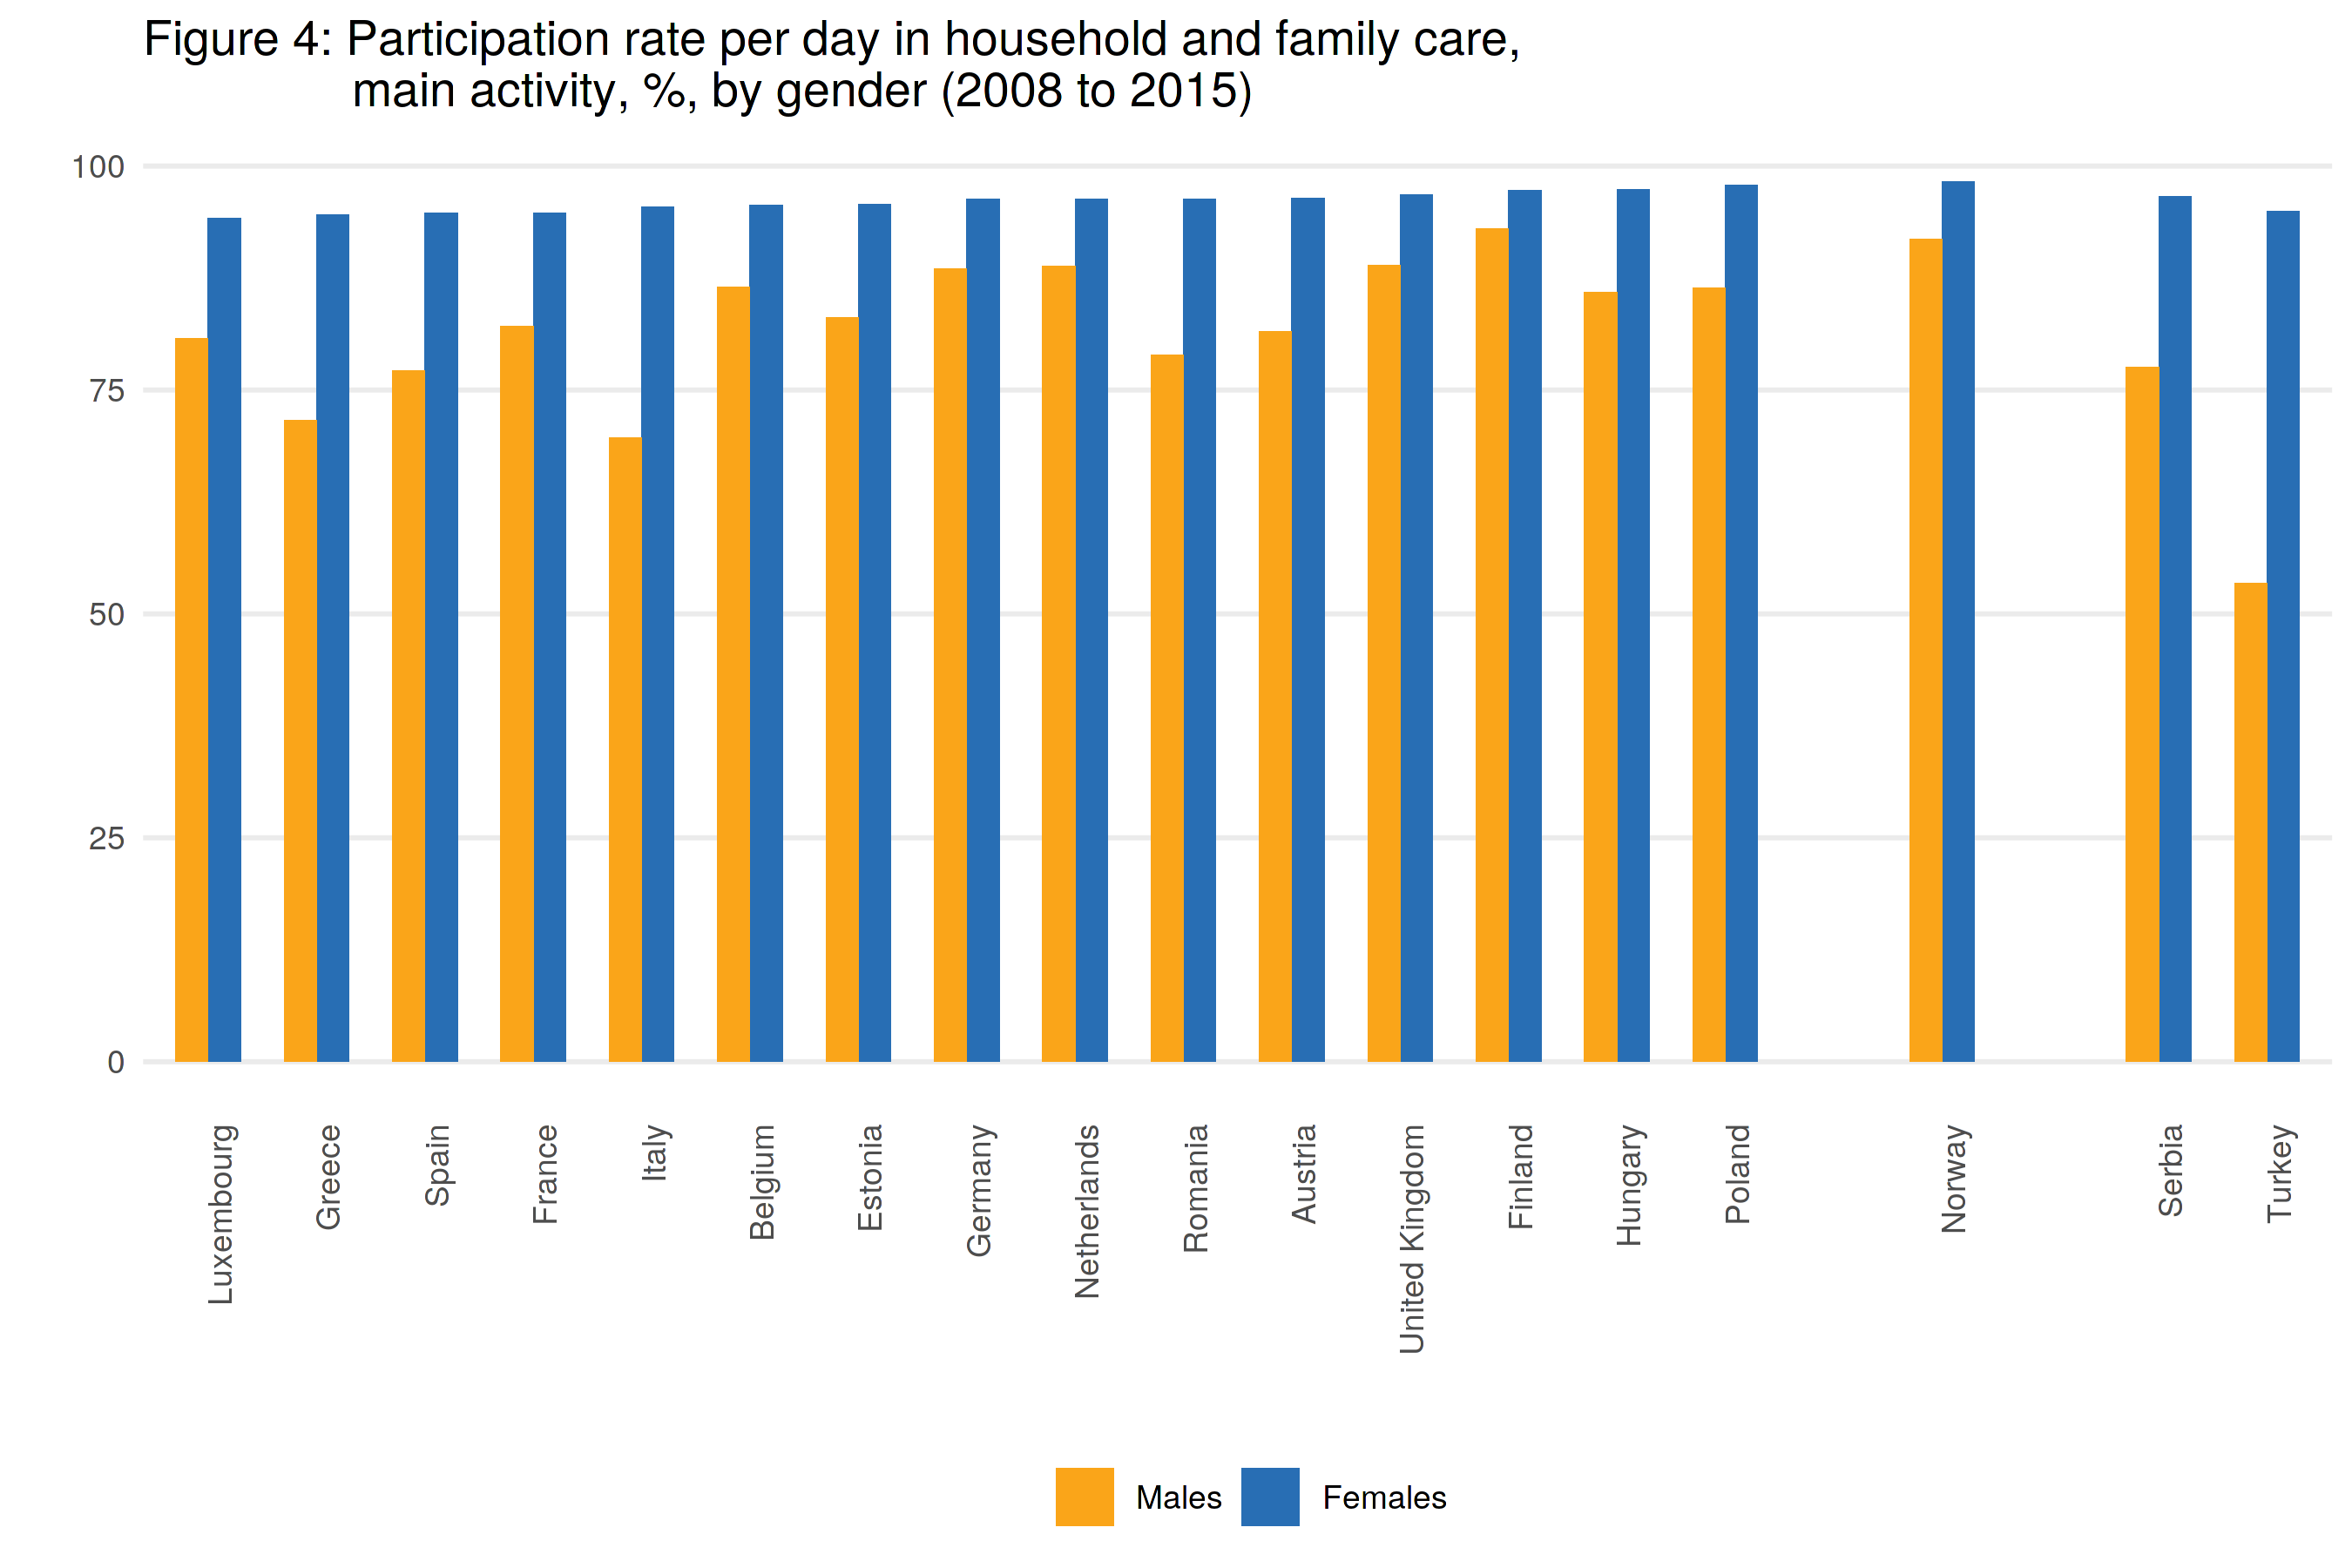

In [22]:
fig4_colors<-c("#FAA519","#286EB4","#F06423")

options(repr.plot.width=9, repr.plot.height=6,repr.plot.res=300)
ggplot(dt,aes(x=geo,y=values)) + theme_minimal() +
  geom_bar(data=dt[sex!="Total"], aes(fill=sex),position="dodge",stat="identity",width=0.6)+
  scale_fill_manual(values = fig4_colors)+
  ggtitle("Figure 4: Participation rate per day in household and family care,\n                main activity, %, by gender (2008 to 2015)") +
  ylab("")+
  xlab("")+
  theme(legend.title = element_blank(),
        legend.position= "bottom",
        axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank())
  


## Figure 5: Participation rate per day in cleaning and food management, by gender, % (2008 to 2015)

The data is this time in the *tus_00educ* dataset. We apply the same filter to the data for the year (`date_filter=yr`) and a modified one for the values in the graph (`filters=list(unit="Participation rate",age="total",acl00="household.*care",sex="male",isced97="^all")`. This time we can use the SDMX REST API to get the data as it is numeric. 

In [13]:
dt<-get_eurostat_data("tus_00educ",filters=list(unit="Participation rate",age="total",acl00="household.*care",sex="male",isced97="^all"),date_filter=eval(yr),label=T,ignore.case=T,exact_match=F,perl=T,stringsAsFactors=F)
dt

unit,sex,acl00,isced97,geo,time,values
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Austria,2010,96.4
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Belgium,2010,95.6
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Germany (until 1990 former territory of the FRG),2010,96.3
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Estonia,2010,95.7
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Greece,2010,94.6
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Spain,2010,94.8
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Finland,2010,97.3
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,France,2010,94.8
Participation rate (%),Females,Household and family care,All ISCED 1997 levels,Hungary,2010,97.4


Then again we keep only the columns with sex, countries and values. Before plotting the values we need to cut the brackets from the name of Germany.

In [14]:
dt$geo<-gsub(" \\(.*\\)","",dt$geo)
dt<-dt[,c("sex","geo","values")]
dt

sex,geo,values
<chr>,<chr>,<dbl>
Females,Austria,96.4
Females,Belgium,95.6
Females,Germany,96.3
Females,Estonia,95.7
Females,Greece,94.6
Females,Spain,94.8
Females,Finland,97.3
Females,France,94.8
Females,Hungary,97.4


We make the graph again with *ggplot*. We have to order by increasing total value of *sex*, add the empty spaces before the EFTA and accession countries. Finally adjust scaling, remove vertical grid lines, column width and resize the plotting area to better see the figure. 

In [16]:
dt_sep<-data.table::data.table(sex=c("Males","Males"),geo=c(" ","  "),values=c(NA,NA))
dt<-rbind(dt,dt_sep)
geo_ord<-dt[(geo %in% eu_ctry_names)&grepl("Females",sex)]
geo_ord<-geo_ord[order(values)]$geo
geo_ord<-c(geo_ord,' ','Norway','  ','Serbia','Turkey')
dt$geo<-factor(dt$geo,levels=geo_ord)
sex_ord<-c('Males','Females')
dt$sex<-factor(dt$sex,levels=sex_ord)

Warning message:
"Removed 2 rows containing missing values (geom_bar)."


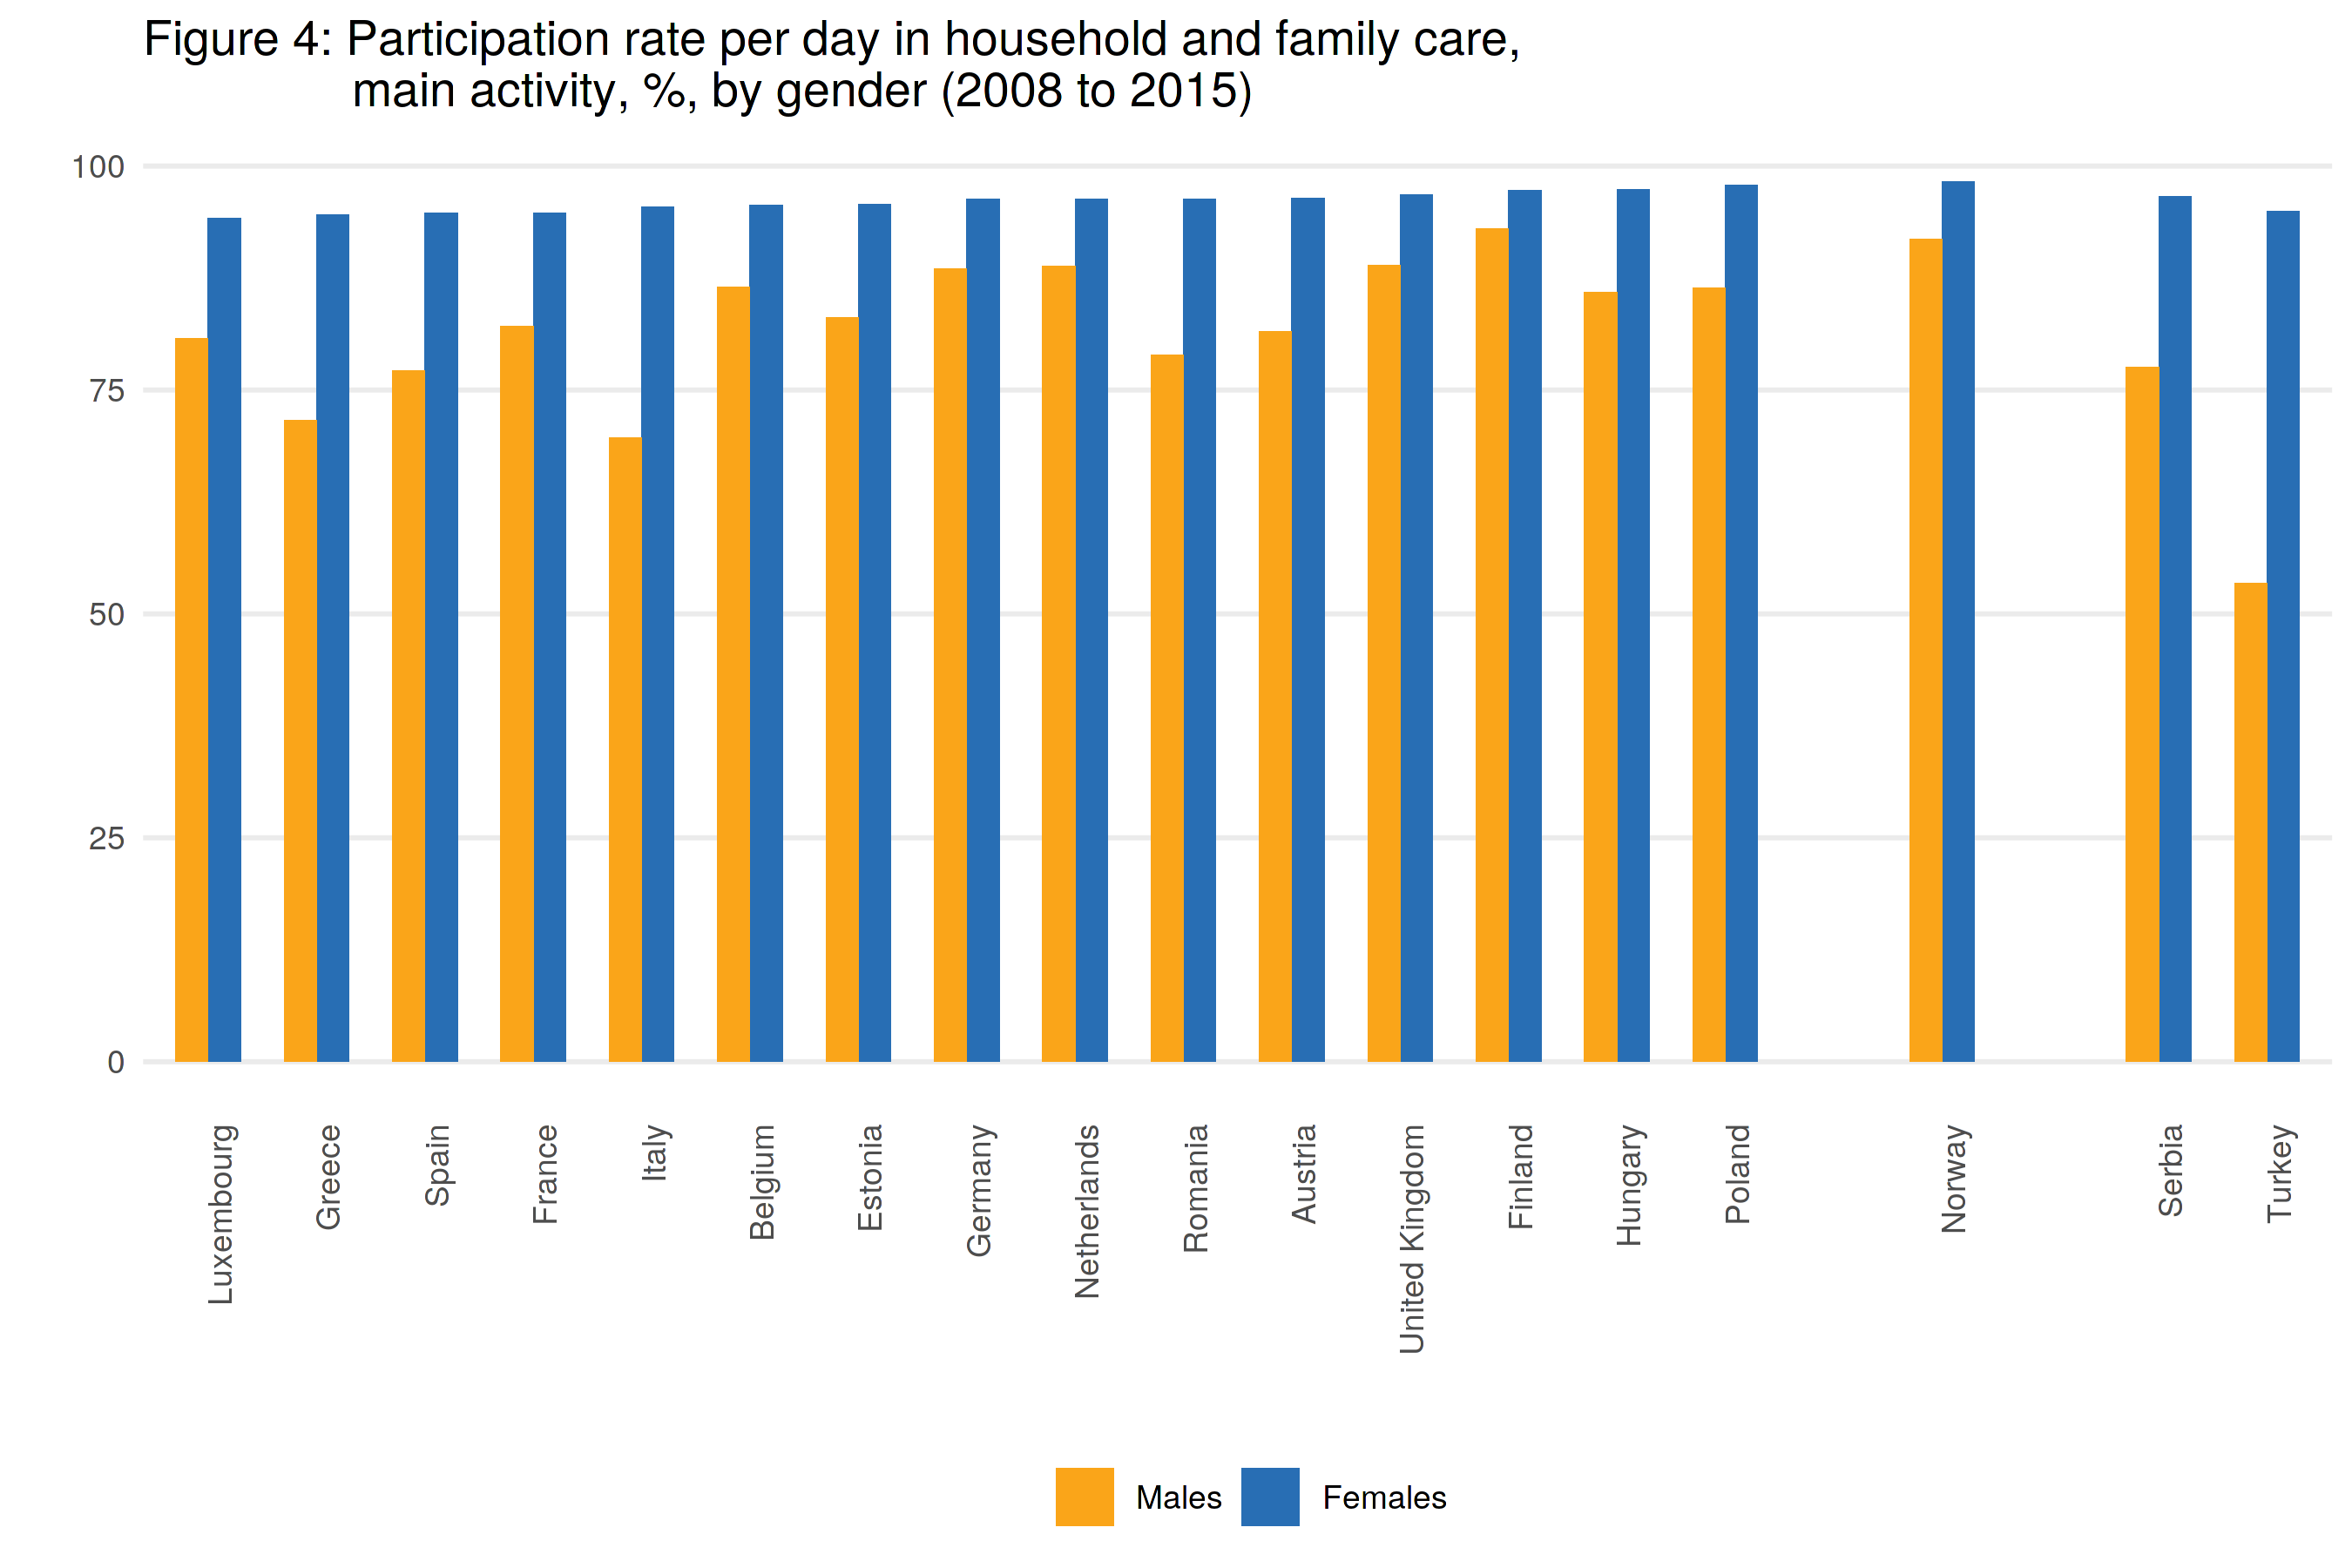

In [22]:
fig4_colors<-c("#FAA519","#286EB4","#F06423")

options(repr.plot.width=9, repr.plot.height=6,repr.plot.res=300)
ggplot(dt,aes(x=geo,y=values)) + theme_minimal() +
  geom_bar(data=dt[sex!="Total"], aes(fill=sex),position="dodge",stat="identity",width=0.6)+
  scale_fill_manual(values = fig4_colors)+
  ggtitle("Figure 5: Participation rate per day in cleaning and food management, by gender, % (2008 to 2015)") +
  ylab("")+
  xlab("")+
  theme(legend.title = element_blank(),
        legend.position= "bottom",
        axis.text.x = element_text(angle = 90, hjust = 1),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.y = element_blank())
  
